# Machine Learning Classification of Land Cover Land Use in and Around Chilumba Malawi

This first section loads Python geospatial packages used in this analysis.

In [1]:
import geowombat as gw
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import os

/Users/rhys/mambaforge/envs/gw-test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Collecting and Loading Sentinel 2 Satellite Imagery

To perform this classification, I downloaded an image of Chilumba Malawi from ESA's Earth Observatory Browser from December 14, 2023. Using the selection tool, I clipped a 10 square km scene without cloud cover and exported Bands 2-5 so to visualize the image in True Color. I selected this particular area for analysis because it contained a mix of sparse impervious surfaces (paved roads, roofs, buildings, and makeshift housing), vegetation, and soil. This area of land does not contain much water (no visible rivers), and I only left a tiny bit of Lake Malawi in the upper lefthand corner of the image.

The code below, loads the image, checks the dimensions, and inspects the bands and datatypes.

This is a link to retrieve the original imagery: https://apps.sentinel-hub.com/eo-browser/?zoom=14&lat=-10.44308&lng=34.22035&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fservices.sentinel-hub.com%2Fogc%2Fwms%2Fbd86bcc0-f318-402b-a145-015f85b9427e&datasetId=S2L2A&fromTime=2023-12-14T00%3A00%3A00.000Z&toTime=2023-12-14T23%3A59%3A59.999Z&layerId=1_TRUE_COLOR&demSource3D=%22MAPZEN%22

In [2]:
with gw.open('EO_Data/Chilumba_Sentinel-2_L2A_True_color-2023-12-14.tiff') as Chilumba:
        display(Chilumba)

<xarray.DataArray (band: 3, y: 140, x: 685)>
dask.array<open_rasterio-9a03a98bda14480fa8f6d79223737634<this-array>, shape=(3, 140, 685), dtype=uint16, chunksize=(3, 8, 685), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * x        (x) float64 34.2 34.2 34.2 34.2 34.2 ... 34.26 34.26 34.26 34.26
  * y        (y) float64 -10.43 -10.43 -10.43 -10.43 ... -10.44 -10.44 -10.44
Attributes: (12/16)
    transform:               (8.984087591240627e-05, 0.0, 34.198036, 0.0, -8....
    crs:                     4326
    res:                     (8.984087591240627e-05, 8.8628571428576e-05)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    _FillValue:              nan
    ...                      ...
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    filename:                EO_Data/Chilumba_Sentinel-2_L2A_True_color-2023-...
    resampling:              nearest
    _data_are_separate:      0
    _data_are_stacked:       0

### Displaying a True Color Image of Chilumba

This code reads in the raster, selects the bands in the correct order from Sentinel-2 sensor to display the image as a human would see it from space. Qualitatively, the image does not have cloud cover. There are a mix of buildlings, roads, vegetation, and soil visible in the image. 

<xarray.DataArray (band: 3, y: 140, x: 685)>
dask.array<open_rasterio-9a03a98bda14480fa8f6d79223737634<this-array>, shape=(3, 140, 685), dtype=uint16, chunksize=(3, 8, 685), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * x        (x) float64 34.2 34.2 34.2 34.2 34.2 ... 34.26 34.26 34.26 34.26
  * y        (y) float64 -10.43 -10.43 -10.43 -10.43 ... -10.44 -10.44 -10.44
Attributes: (12/16)
    transform:               (8.984087591240627e-05, 0.0, 34.198036, 0.0, -8....
    crs:                     4326
    res:                     (8.984087591240627e-05, 8.8628571428576e-05)
    is_tiled:                0
    nodatavals:              (nan, nan, nan)
    _FillValue:              nan
    ...                      ...
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    filename:                EO_Data/Chilumba_Sentinel-2_L2A_True_color-2023-...
    resampling:              nearest
    _data_are_separate:      0
    _data_are_stacked:       0


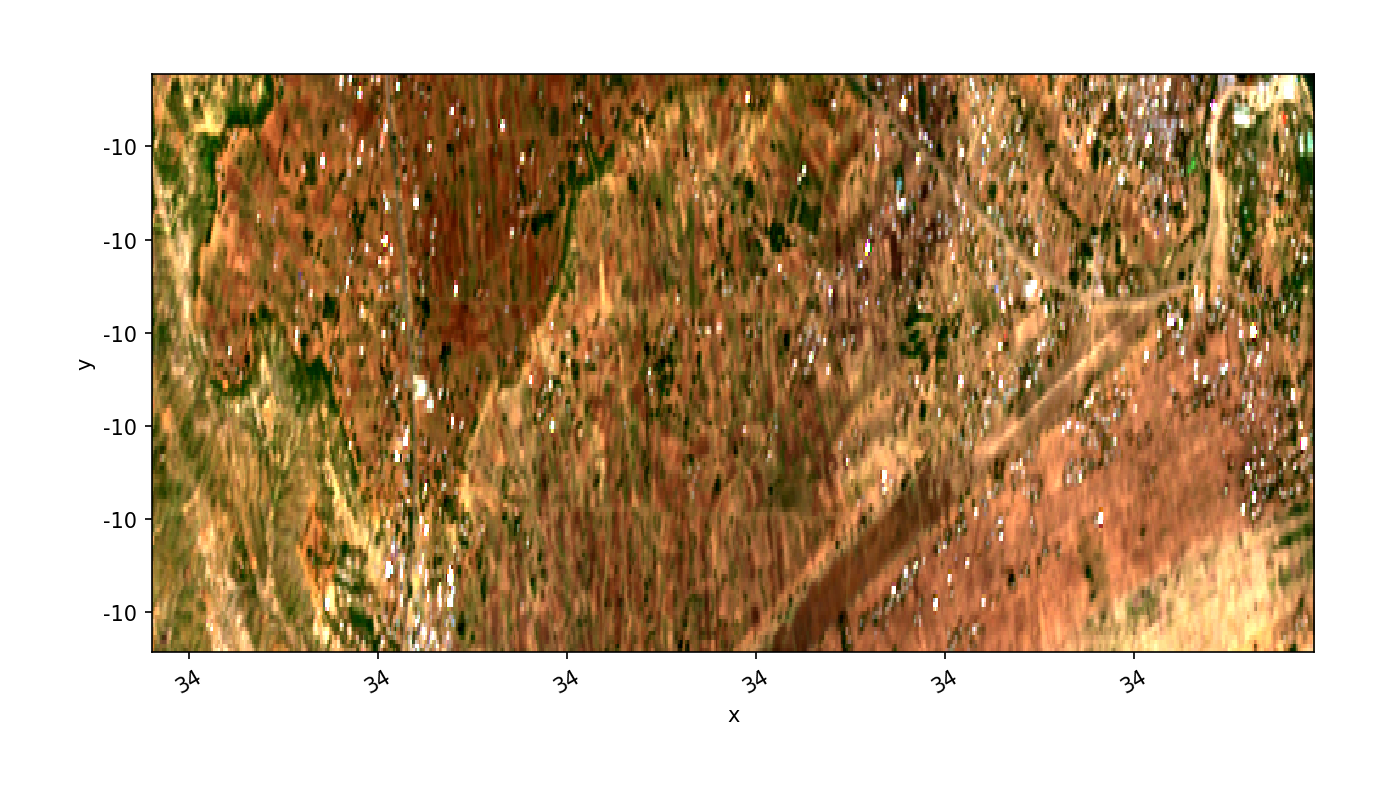

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=150, figsize=(10,5))

with gw.open('EO_Data/Chilumba_Sentinel-2_L2A_True_color-2023-12-14.tiff') as Chilumba:
    Chilumba.where(Chilumba != 0).sel(band=[1, 2, 3]).gw.imshow(robust=True, ax=ax)
    print(Chilumba)

## Unsupervised Land Cover Classification using K Means.

K Means is a clustering algorithm that automatically groups objects in data space as well as geographic space. In other words, K Means clustering can help identify pixels that are both similar and near each other and differentiate pixels that are dissimilar and far from each other. K Means is unsupervised because it does not require a user to indicate which features are important in determining similarity -- it does not require training data or labels. This is an especially useful tool in geospatial modeling because it is difficult to label components in satellite imagery at scale. However, K Means requires the user to select the number of clusters in advance and can be computationally intense. 

The image below shows how the K Means algorithm labels the image by dividing pixels into four groups or clusters. I selected 4 clusters here to more easily contrast with the supervised model below.

Qualitatively, comparing this unsupervised output with the True Color image above shows that the model did a fairly good job of picking out features in the image. For example, the large swaths of dark purple match the areas of dark soil or sand in the True Color image. Additionally, the turquoise sections match the shape and distribution of many of the impervious surfaces (houses, buildings). However, it appears that the K Means algorithm confused light sand or soil for impervious surfaces in the lower righthand corner. 

**Citation** 

Description of K Means Algorithm in Geospatial Applications derived from my notes from Dr. Engstrom's Digital Image Processing Class (Lecture 6) from Spring, 2023 at George Washington University.


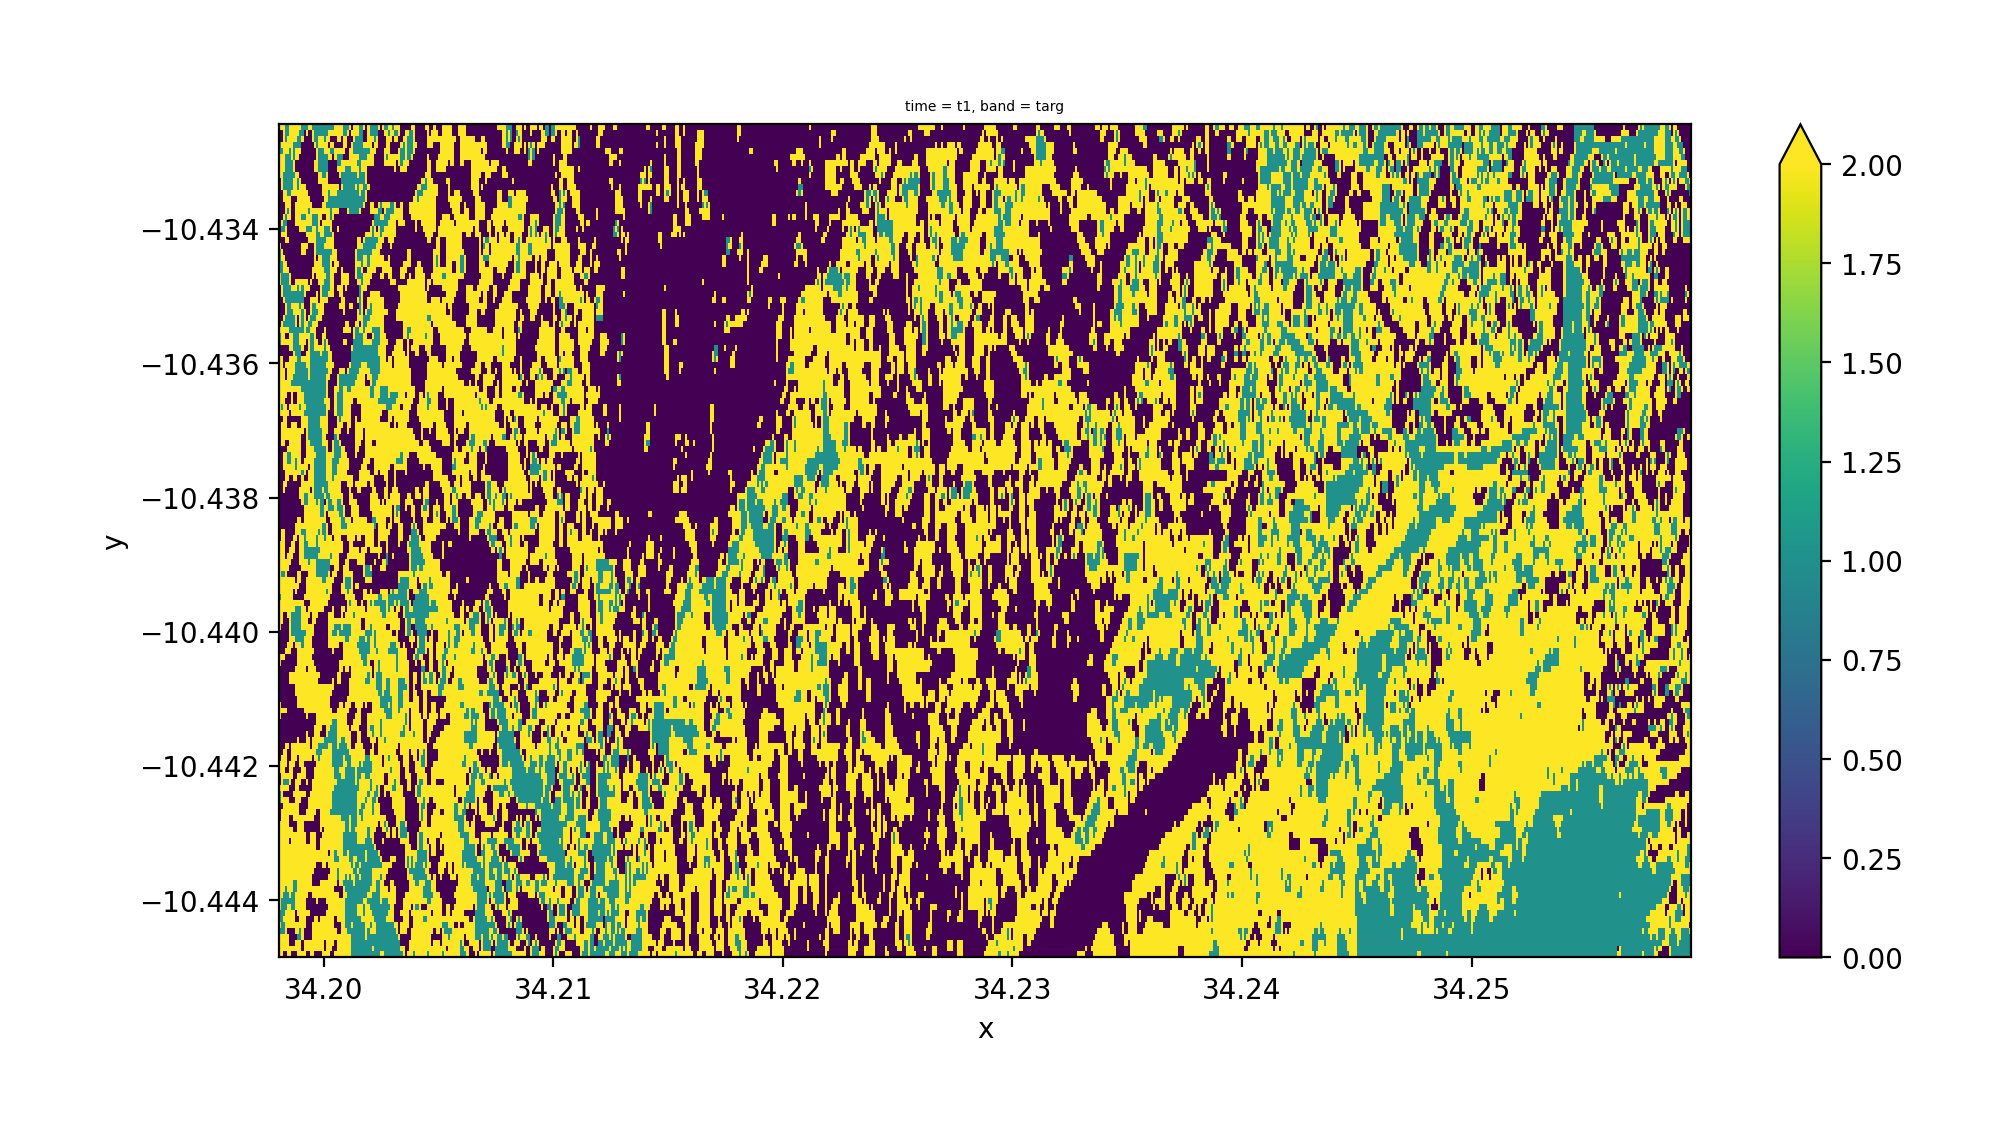

In [4]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from geowombat.ml import  fit_predict

cl = Pipeline([ ('clf', KMeans(n_clusters=4, random_state=0))])

fig, ax = plt.subplots(dpi=200,figsize=(10,5))

# Fit_predict unsupervised classifier
with gw.open(os.path.join('./EO_Data','Chilumba_Sentinel-2_L2A_True_color-2023-12-14.tiff')) as src:
        y= fit_predict(src, cl)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

# Supervised Classification

To perform a supervised classificaiton, the model needs training data. I generated the training data by creating and manually labeling polygons in QGIS and exporting the feature as a shape file. 

Note, this training data contains a class imbalance for water because this image mostly contains dry land. Each of the other classes have 20 training data points, whereas water only has ~5, and these points are all clustered in one corner of the image. 

## Load Labels

This table serves as a codebook for our labels. Machine Learning models require that labels be encoded rather than strings. The code below loads the shape file and filters for any invalid geometries. 


| Numeric Code | Land Cover Type  |  
|-------------------|--------------------| 
| 0          | Impervious Surface        | 
|1          | Vegetation          |   
| 2         | Soil           |
| 3         | Water         |

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shapely

labels = gpd.read_file(os.path.join('./EO_Data','Chilumba_LC.shp'))
#Here we are filtering our training data for any broken geometries
labels = labels[labels['geometry'].is_valid]
labels

,LC,geometry
0,0,"POLYGON ((34.20559 -10.43796, 34.20576 -10.438..."
1,0,"POLYGON ((34.21198 -10.43902, 34.21265 -10.439..."
2,0,"POLYGON ((34.21028 -10.43596, 34.21056 -10.435..."
3,0,"POLYGON ((34.20902 -10.43833, 34.20925 -10.438..."
4,0,"POLYGON ((34.20905 -10.43392, 34.20930 -10.433..."
...,...,...
68,3,"POLYGON ((34.25917 -10.43250, 34.25953 -10.432..."
69,3,"POLYGON ((34.25920 -10.43244, 34.25931 -10.432..."
70,3,"POLYGON ((34.25942 -10.43281, 34.25956 -10.432..."
71,3,"POLYGON ((34.25931 -10.43264, 34.25945 -10.432..."


In [6]:
#Check that labels are encoded correctly.
labels.dtypes

LC             int64
geometry    geometry
dtype: object

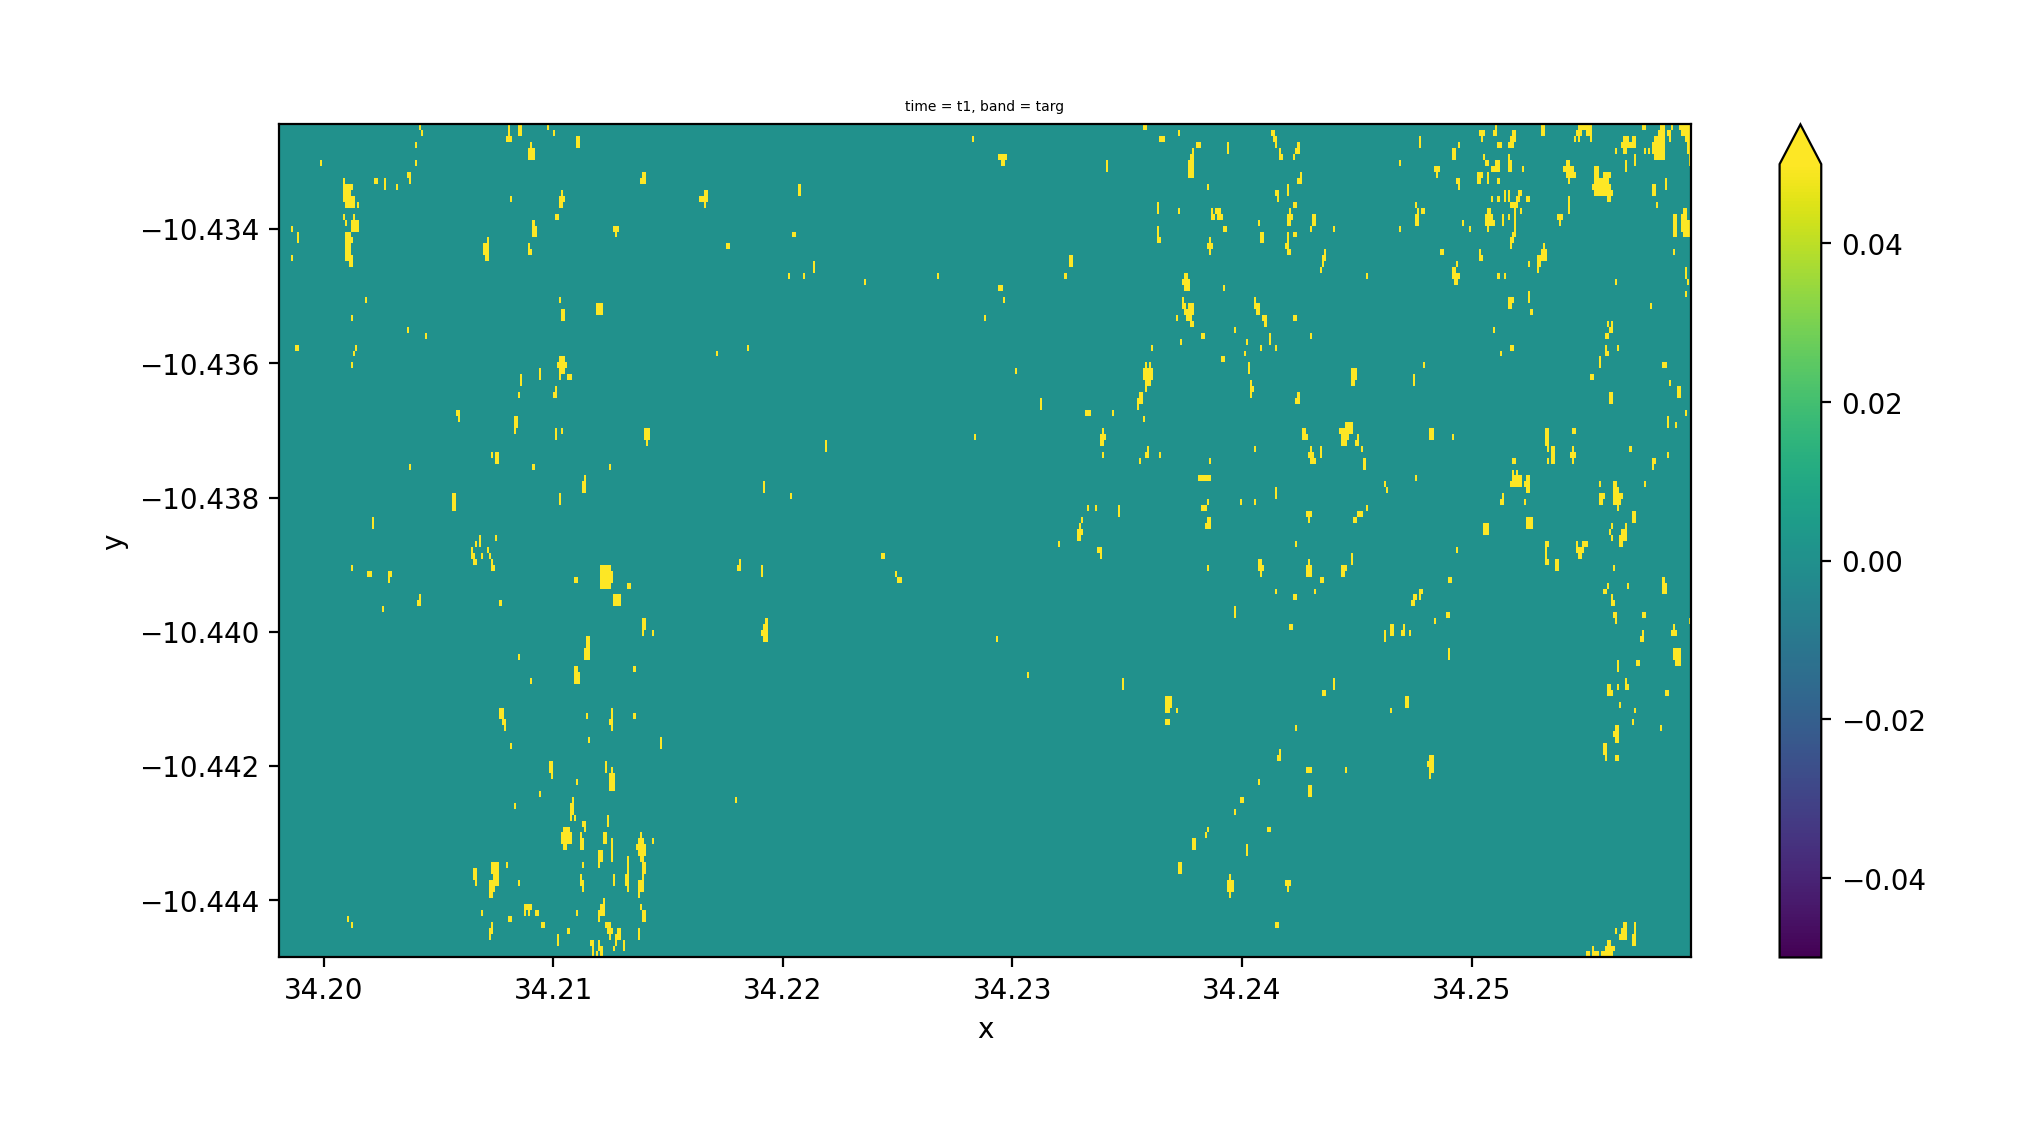

In [7]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from geowombat.ml import  fit_predict 

fig, ax = plt.subplots(dpi=200,figsize=(10,5))
# Use a data pipeline
pipe = Pipeline([ ('scaler', StandardScaler()),
                ('pca', PCA()),
                ('clf', GaussianNB())])

# Fit the classifier
with gw.open(os.path.join('./EO_Data','Chilumba_Sentinel-2_L2A_True_color-2023-12-14.tiff')) as src:
        y = fit_predict(src, pipe, labels, col='LC')
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

### Evaluating the Supervised Model (Part 1)

Qualitatively, this image shows that the model appears to effectively predict some of the imprevious surfaces-- it clearly picks out many buildings-- but fails to successfully differentiate vegetation, soil water, and misses many man made structures. The class imbalance referenced above, and relatively small training dataset, likely contribute to some underfitting in the model. Furthermore, using the robust flag, which produces an image that is classified by a robust regression, reduces the impact of outliers in the training data and prevents overfitting. This flag might be contributing to this model's issues, but it likely makes it more generalizable for picking out impervious surfaces from surrounding land. 

**Robust Regression Flag**

https://geowombat.readthedocs.io/en/latest/api/geowombat.radiometry.Topo.html#geowombat.radiometry.Topo.norm_topo

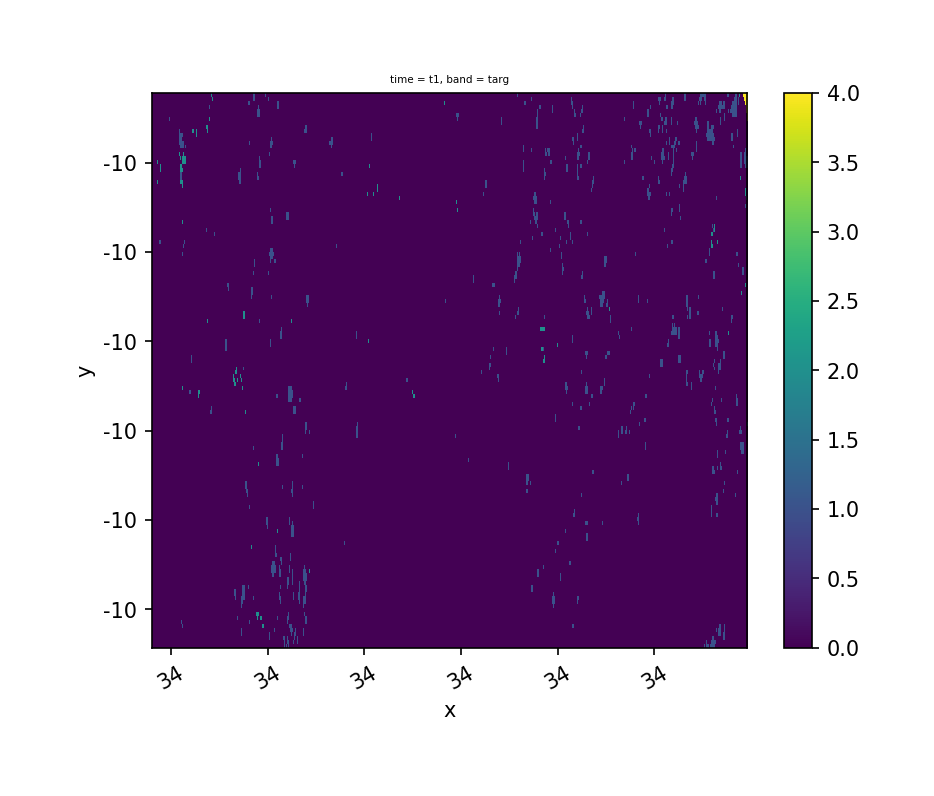

In [8]:
with gw.open(os.path.join('./EO_Data','Chilumba_Sentinel-2_L2A_True_color-2023-12-14.tiff')) as src:
        y = fit_predict(src, pipe, labels, col='LC')
        y.sel(band='targ').gw.imshow()

### Evaluating the Supervised Model (Part 2)

This output image shows that without using robust regression, the model predicted four classes in the image rather than two, more closely matching the training data. Notably, it successfully labeled water in the upper righthand corner, and it looks like the model successfully labeled many of the impervious surfaces. In the upper lefthand corner (in turquoise) and throughout the image, it looks like the model identified some patches of vegetation, but missed some larger sections. Regardless of the regression flag, both images show that the model is having trouble differentating vegetation and soil, and to improve this would likely require better training data. 

In general, this version without the robust flag might be prone to overfitting and less generalizable to other scenes in Malawi. 

# Save Supervised Predicted Land Cover Results and Write an Image to Disk

This code exports a raster of the predicted labels so it can be saved, stored, and used in future research without rerunning the model. This analysis shows how unsupervised and supervised learning can be used to develop predictive models to automatically label land cover and land use in satellite imagery. 

In [9]:
import xarray as xr
import numpy as np 
with gw.open(os.path.join('./EO_Data','Chilumba_Sentinel-2_L2A_True_color-2023-12-14.tiff')) as src:
        y = fit_predict(src, pipe, labels, col='LC')
        y.gw.to_raster('./EO_Data/Supervised_output.tif', overwrite=True)

100%|██████████| 18/18 [00:00<00:00, 361.46it/s]
